# XGB Regressor
XGBoost excels at complex, multivariate data with sharp changes, modeling non-linearities for high accuracy, while Prophet shines with clear seasonality/holidays, offering fast, interpretable, univariate forecasts, handling missing data easily, but potentially struggling with very complex patterns. 

In [42]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")
display(df_train_clean.head())
display(df_test_clean.head())


Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,day_of_week,is_saturday,is_sunday,sunshine_duration,temperature_2m_mean,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month
0,2013-07-01,0.0,6.0,17.8375,15.0,1.0,148.828353,148.828353,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
1,2013-07-01,0.0,6.0,17.8375,15.0,2.0,535.856285,221.786925,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
2,2013-07-01,0.0,6.0,17.8375,15.0,3.0,201.198426,592.534505,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
3,2013-07-01,0.0,6.0,17.8375,15.0,4.0,65.890169,311.369828,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
4,2013-07-01,0.0,6.0,17.8375,15.0,5.0,317.475875,109.314600,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,id,Warengruppe_umsatz,day_of_week,is_saturday,is_sunday,sunshine_duration,temperature_2m_mean,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month
0,2018-08-01,0.0,0.0,23.7625,10.0,1808011,1.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8
1,2018-08-01,0.0,0.0,23.7625,10.0,1808012,2.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8
2,2018-08-01,0.0,0.0,23.7625,10.0,1808013,3.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8
3,2018-08-01,0.0,0.0,23.7625,10.0,1808014,4.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8
4,2018-08-01,0.0,0.0,23.7625,10.0,1808015,5.0,2,0,0,50441.36,21.4,14.011489,0.0,1.0,0.0,8


In [43]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)





In [46]:
# Selected variables
# reducing variables to check if it improves model performance
# take only a subset of columns
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'school_holiday', 'KielerWoche_kiwo']
df_train_clean = df_train_clean[selected_columns]
df_validation_clean = df_validation_clean[selected_columns]


In [47]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','public_holiday','next_day_holiday','month','school_holiday','KielerWoche_kiwo']  # adjust based on your data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean_cat = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False)
df_validation_clean_cat = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)

# XGBoost

R2 on train: 0.956
R2 on validation: 0.783
MAPE on validation: 0.226
Features
Temperatur_weather: 0.015
Warengruppe_umsatz_1.0: 0.008
Warengruppe_umsatz_2.0: 0.449
Warengruppe_umsatz_3.0: 0.035
Warengruppe_umsatz_4.0: 0.003
Warengruppe_umsatz_5.0: 0.165
Warengruppe_umsatz_6.0: 0.003
day_of_week_0: 0.010
day_of_week_1: 0.003
day_of_week_2: 0.004
day_of_week_3: 0.004
day_of_week_4: 0.002
day_of_week_5: 0.027
day_of_week_6: 0.053
month_1: 0.006
month_2: 0.011
month_3: 0.007
month_4: 0.010
month_5: 0.011
month_6: 0.003
month_7: 0.021
month_8: 0.039
month_9: 0.006
month_10: 0.009
month_11: 0.005
month_12: 0.039
school_holiday_0.0: 0.041
school_holiday_1.0: 0.000
KielerWoche_kiwo_0.0: 0.011
KielerWoche_kiwo_1.0: 0.000


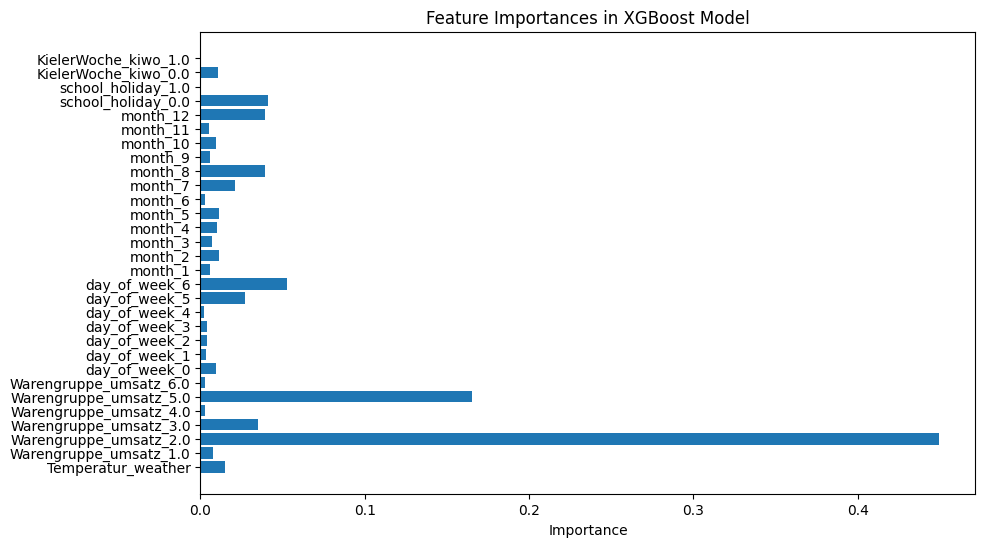

In [51]:
# xgbost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# prepare features and target (same as before)
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# fit XGBoost
xgb_model = XGBRegressor(n_estimators=290, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_validation_pred = xgb_model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.3f}")
print(f"R2 on validation: {r2_validation:.3f}")
print(f"MAPE on validation: {mape_validation:.3f}")

print("Features")
feature_importances = xgb_model.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.3f}")

# optional: plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost Model')
plt.show()


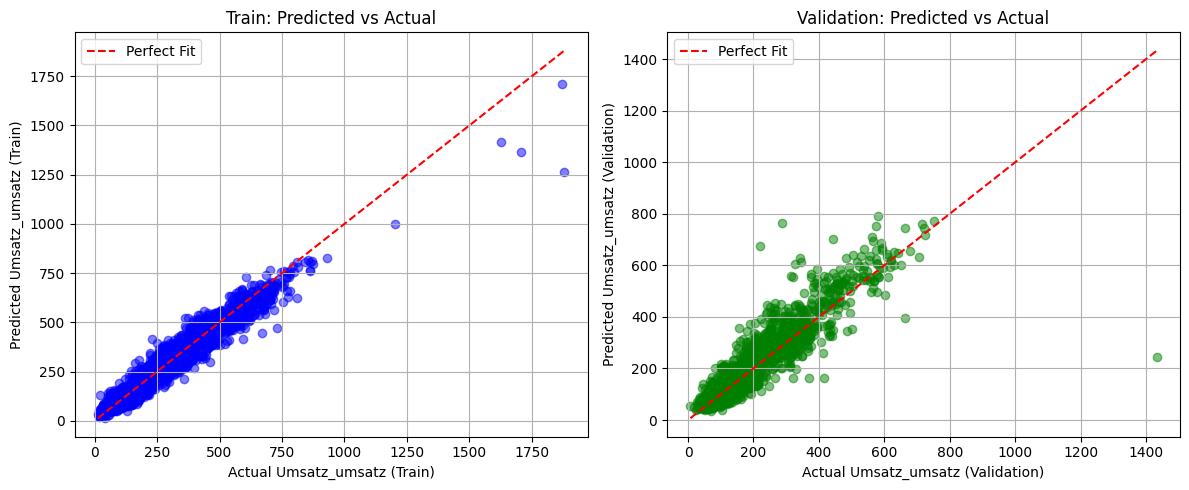

In [52]:
# plot predicted vs actual for train and validation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## xboost combined

In [41]:

# merge df_train_clean and df_validation_clean and create df_combined
df_combined = pd.concat([df_train_clean, df_validation_clean], ignore_index=True)
df_combined.head()

,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Warengruppe_umsatz,Umsatz_umsatz,day_of_week,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month
0,0.0,6.0,17.8375,15.0,1.0,148.828353,0,8.618242,0.0,1.0,0.0,7
1,0.0,6.0,17.8375,15.0,2.0,535.856285,0,8.618242,0.0,1.0,0.0,7
2,0.0,6.0,17.8375,15.0,3.0,201.198426,0,8.618242,0.0,1.0,0.0,7
3,0.0,6.0,17.8375,15.0,4.0,65.890169,0,8.618242,0.0,1.0,0.0,7
4,0.0,6.0,17.8375,15.0,5.0,317.475875,0,8.618242,0.0,1.0,0.0,7


In [ ]:
# reducing variables
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'school_holiday', 'KielerWoche_kiwo']
df_combined = df_combined[selected_columns]

In [ ]:
# ...existing code...

categorical_cols = ['Warengruppe_umsatz', 'day_of_week','public_holiday','next_day_holiday','month','school_holiday','KielerWoche_kiwo']  # adjust based on your data

categorical_cols = [col for col in categorical_cols if col in df_combined.columns]
df_combined = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=False)

# do categorical encoding for test set as well
df_test_clean = pd.get_dummies(df_test_clean, columns=categorical_cols, drop_first=False)

#save id column before reindexing
df_test_id = df_test_clean['id']


df_test_clean = df_test_clean.reindex(columns=df_combined.columns, fill_value=0)
# prepare combined features and target
X_combined = df_combined.drop(columns=[target])
y_combined = df_combined[target]

# fit XGBoost on combined data
xgb_model_combined = XGBRegressor(n_estimators=90, learning_rate=0.1, random_state=42)
xgb_model_combined.fit(X_combined, y_combined)

#print feature importances for combined model
print("Features for combined model")
feature_importances_combined = xgb_model_combined.feature_importances_
for feature, importance in zip(X_combined.columns, feature_importances_combined):
    print(f"{feature}: {importance:.3f}")


# only predict on test set
y_test = df_test_clean[target]



X_test = df_test_clean.drop(columns=[target])
y_test_pred = xgb_model_combined.predict(X_test)

# head y_test_pred
print("Test set predictions (first 10):")

print(df_test_clean.head())

# combine df_test_id with y_test_pred into a new dataframe df_xboost_test_predictions
df_xboost_test_predictions = pd.DataFrame({
    'id': df_test_id,
    'umsatz': y_test_pred
})
print(df_xboost_test_predictions.head(10))

# save df_xboost_test_predictions to ../data/processed/xgboost_test_predictions.csv
df_xboost_test_predictions.to_csv("../data/processed/xgboost_test_predictions.csv", index=False)


Columns in df_train_clean:
['Bewoelkung_weather', 'Temperatur_weather', 'Windgeschwindigkeit_weather', 'Umsatz_umsatz', 'sunshine_hours', 'Warengruppe_umsatz_1.0', 'Warengruppe_umsatz_2.0', 'Warengruppe_umsatz_3.0', 'Warengruppe_umsatz_4.0', 'Warengruppe_umsatz_5.0', 'Warengruppe_umsatz_6.0', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'public_holiday_0.0', 'public_holiday_1.0', 'next_day_holiday_0.0', 'next_day_holiday_1.0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'school_holiday_0.0', 'school_holiday_1.0', 'KielerWoche_kiwo_0.0', 'KielerWoche_kiwo_1.0']
Features for combined model
Bewoelkung_weather: 0.004
Temperatur_weather: 0.015
Windgeschwindigkeit_weather: 0.005
sunshine_hours: 0.002
Warengruppe_umsatz_1.0: 0.008
Warengruppe_umsatz_2.0: 0.540
Warengruppe_umsatz_3.0: 0.030
Warengruppe_umsatz_4.0: 0.002
Warengruppe